In [52]:
import torchhd
import numpy as np
import matplotlib.pyplot as plt

## FHHR representation and fractional power encoding

In [53]:
# elementwise multiplication
def binding(*hvs): 
    result = np.ones_like(hvs[0], dtype=complex)
    for hv in hvs:
        result *= hv
    return result

# elementwise sum
def bundle(*hvs):
    bundles = np.sum(hvs, axis=0)
    return bundles 

# define similarity as the real part of the Hermitian inner product of hx and hy divided by the dim of hx
def fhrr_similarity(hx, hy):
    conjugate = np.conjugate(hy)
    return np.real(np.dot(hx, conjugate)) / len(hx)

In [338]:
def gen_basis(D, n, distribution='gaussian', covariance=None, random_seed=37):
    """
    Generates encoding codebook for FHRR representations. Takes in n features outputs (n x D) encodebook in unexponentiated form.
    Args:
        D (int) - dimension of resulting vectors
        n (int) - number of features 
        distribution (str) - the type of distribution (gaussian or uniform)
        covariance (np.ndarray, optional) - n x n matrix for gaussian distribution)
    Returns:
        np.ndarray - encoding basis in unexponentiated form W (n x D)
    """
    np.random.seed(random_seed)
    if distribution == 'gaussian':
        if covariance is None:
            covariance = np.eye(n)
        basis = np.random.multivariate_normal(np.zeros(n), covariance, D).T
    else: # uniform
        basis = np.random.uniform(0, 2 * np.pi, (n, D))
    return basis

In [211]:
def encode_feature(C, features):
    """
    Encodes feature vectors using FHRR with optional fractional power encoding. 
    Args:
        C (np.ndarray) - the codebook encoded in unexponentiated form W (n x D)
        features (np.ndarray) - feature vectors to encode, every feature is a row (batch size x n) 
        
    Returns:
        np.ndarray - encoded features in FHRR form (batch size x D) , complex values
    """
    phases = np.dot(features, C)
    return np.exp(1j * phases)

## Kernel behavior for low dimension features

In [303]:
def visualize_1d_gaussian(D=500, variance=1.0, feature_range=(-4, 4), num_points=100):
    """Visualize kernel behavior for 1D feature space with Gaussian distribution"""
    
    codebook = gen_basis(D, 1, distribution="gaussian", covariance=np.array([[variance]]))
    
    # reference point at 0
    reference = np.array([0.0])
    encoded_reference = encode_feature(codebook, reference)
    
    # test points across the feature range
    feature_diffs = np.linspace(feature_range[0], feature_range[1], num_points)
    test_features = feature_diffs.reshape(-1, 1)
    encoded_tests = encode_feature(codebook, test_features)
    
    # similarities
    similarities = np.array([fhrr_similarity(encoded_reference, encoded_test) 
                            for encoded_test in encoded_tests])
    
    plt.figure(figsize=(10, 6))
    plt.plot(feature_diffs, similarities)
    plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
    plt.axvline(x=0, color='r', linestyle='-', alpha=0.3)
    plt.grid(True, alpha=0.3)
    plt.title(f'1D Gaussian Kernel (σ² = {variance})')
    plt.xlabel('Feature Difference')
    plt.ylabel('Similarity')
    plt.ylim(-0.2, 1.05)
    plt.show()
    
    return similarities, feature_diffs

In [346]:
def visualize_2d_diagonal_gaussian(D=1000, variance=1.0, feature_range=(-4, 4), num_points=50):
    """Visualize kernel behavior for 2D feature space with diagonal Gaussian covariance"""
    
    cov_matrix = np.array([[variance, 0], [0, variance]])
    codebook = gen_basis(D, 2, distribution="gaussian", covariance=cov_matrix)
    
    
    reference = np.array([0.0, 0.0])
    encoded_reference = encode_feature(codebook, reference)
    
    
    x = np.linspace(feature_range[0], feature_range[1], num_points)
    y = np.linspace(feature_range[0], feature_range[1], num_points)
    X, Y = np.meshgrid(x, y)
    test_features = np.column_stack((X.flatten(), Y.flatten()))
    encoded_tests = encode_feature(codebook, test_features)
    
    
    similarities = np.array([fhrr_similarity(encoded_reference, encoded_test) 
                            for encoded_test in encoded_tests])
    similarities_grid = similarities.reshape(num_points, num_points)
    

    plt.figure(figsize=(10, 8))
    plt.imshow(similarities_grid, extent=[feature_range[0], feature_range[1], 
                                         feature_range[0], feature_range[1]], 
               origin='lower', cmap='viridis', interpolation='bilinear')
    plt.colorbar(label='Similarity')
    plt.grid(False)
    plt.title(f'2D Gaussian Kernel with Diagonal Covariance (σ² = {variance})')
    plt.xlabel('Feature Difference (x)')
    plt.ylabel('Feature Difference (y)')
    plt.show()
    
    return similarities_grid, X, Y

In [347]:
def visualize_bound_1d_gaussian(D=1000, variance=1.0, feature_range=(-4, 4), num_points=50):
    """
    Visualize kernel behavior for two 1D features bound together, showing equivalence to a 
    2D multivariate Gaussian with a diagonal covariance matrix.
    """
    
    codebook1 = gen_basis(D, 1, distribution="gaussian", covariance=np.array([[variance]]))
    codebook2 = gen_basis(D, 1, distribution="gaussian", covariance=np.array([[variance]]), random_seed=42)

    
    reference1 = np.array([0.0])
    reference2 = np.array([0.0])
    encoded_reference1 = encode_feature(codebook1, reference1)
    encoded_reference2 = encode_feature(codebook2, reference2)

    
    bound_reference = binding(encoded_reference1, encoded_reference2)

    # grid of feature differences
    x = np.linspace(feature_range[0], feature_range[1], num_points)
    y = np.linspace(feature_range[0], feature_range[1], num_points)
    X, Y = np.meshgrid(x, y)

    # flatten the grid for easier processing
    feature_diffs1 = X.flatten()
    feature_diffs2 = Y.flatten()

    
    encoded_tests1 = encode_feature(codebook1, feature_diffs1.reshape(-1, 1))
    encoded_tests2 = encode_feature(codebook2, feature_diffs2.reshape(-1, 1))
    bound_tests = binding(encoded_tests1, encoded_tests2)

    
    similarities = np.array([fhrr_similarity(bound_reference, bound_test) for bound_test in bound_tests])
    similarities_grid = similarities.reshape(num_points, num_points)

    
    plt.figure(figsize=(10, 8))
    plt.imshow(similarities_grid, extent=[feature_range[0], feature_range[1], 
                                          feature_range[0], feature_range[1]], 
               origin='lower', cmap='viridis', interpolation='bilinear')
    plt.colorbar(label='Similarity')
    plt.title(f'Bound 1D Gaussians Contour (σ² = {variance})')
    plt.xlabel('Feature Difference (x)')
    plt.ylabel('Feature Difference (y)')
    plt.show()

    return similarities_grid, X, Y




In [348]:
def visualize_2d_nondiagonal_gaussian(D=1000, feature_range=(-4, 4), num_points=50):
    """Visualize kernel behavior for 2D feature space with non-diagonal Gaussian covariance""" 
    # correlation of 0.7 for demonstration
    variance = 1.0
    correlation = 0.7
    cov_matrix = np.array([[variance, correlation * variance], 
                           [correlation * variance, variance]])
    
    codebook = gen_basis(D, 2, distribution="gaussian", covariance=cov_matrix)
    
    
    reference = np.array([0.0, 0.0])
    encoded_reference = encode_feature(codebook, reference)
    
    # test points
    x = np.linspace(feature_range[0], feature_range[1], num_points)
    y = np.linspace(feature_range[0], feature_range[1], num_points)
    X, Y = np.meshgrid(x, y)
    test_features = np.column_stack((X.flatten(), Y.flatten()))
    encoded_tests = encode_feature(codebook, test_features)
    

    similarities = np.array([fhrr_similarity(encoded_reference, encoded_test) 
                            for encoded_test in encoded_tests])
    similarities_grid = similarities.reshape(num_points, num_points)
    

    plt.figure(figsize=(10, 8))
    contour = plt.contourf(X, Y, similarities_grid, levels=20, cmap='viridis')
    plt.colorbar(contour, label='Similarity')
    plt.grid(True, alpha=0.3)
    plt.title(f'2D Gaussian Kernel with Non-Diagonal Covariance (Correlation = {correlation})')
    plt.xlabel('Feature Difference (x)')
    plt.ylabel('Feature Difference (y)')
    plt.show()
    
    return similarities_grid, X, Y, cov_matrix

In [349]:
def visualize_1d_uniform(D=1000, feature_range=(-4*np.pi, 4*np.pi), num_points=200):
    """Visualize kernel behavior for 1D feature space with uniform distribution"""
    codebook = gen_basis(D, 1, distribution="uniform")
    
    reference = np.array([0.0])
    encoded_reference = encode_feature(codebook, reference)
    
    feature_diffs = np.linspace(feature_range[0], feature_range[1], num_points)
    test_features = feature_diffs.reshape(-1, 1)
    encoded_tests = encode_feature(codebook, test_features)
    
    similarities = np.array([fhrr_similarity(encoded_reference, encoded_test) 
                            for encoded_test in encoded_tests])
    
    # theoretical sinc function for comparison
    def sinc(x):
        return np.sinc(x / np.pi)  # numpy's sinc is sin(πx)/(πx)
    
    theoretical = sinc(feature_diffs)
    
    plt.figure(figsize=(10, 6))
    plt.plot(feature_diffs, similarities, label='FHRR Similarity')
    plt.plot(feature_diffs, theoretical, '--', label='Theoretical sinc')
    plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
    plt.axvline(x=0, color='r', linestyle='-', alpha=0.3)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.title('1D Uniform Distribution Kernel')
    plt.xlabel('Feature Difference')
    plt.ylabel('Similarity')
    plt.ylim(-0.4, 1.05)
    plt.show()
    
    return similarities, feature_diffs, theoretical

In [350]:
def visualize_2d_uniform(D=1000, feature_range=(-4*np.pi, 4*np.pi), num_points=100):
    """Visualize kernel behavior for 2D feature space with uniform distribution"""
    codebook = gen_basis(D, 2, distribution="uniform")
    
    reference = np.array([0.0, 0.0])
    encoded_reference = encode_feature(codebook, reference)
    
    x = np.linspace(feature_range[0], feature_range[1], num_points)
    y = np.linspace(feature_range[0], feature_range[1], num_points)
    X, Y = np.meshgrid(x, y)
    test_features = np.column_stack((X.flatten(), Y.flatten()))
    encoded_tests = encode_feature(codebook, test_features)
    
    similarities = np.array([fhrr_similarity(encoded_reference, encoded_test) 
                            for encoded_test in encoded_tests])
    similarities_grid = similarities.reshape(num_points, num_points)
    
    plt.figure(figsize=(10, 8))
    contour = plt.contourf(X, Y, similarities_grid, levels=20, cmap='viridis')
    plt.colorbar(contour, label='Similarity')
    plt.grid(True, alpha=0.3)
    plt.title('2D Uniform Distribution Kernel')
    plt.xlabel('Feature Difference (x)')
    plt.ylabel('Feature Difference (y)')
    plt.show()
    
    return similarities_grid, X, Y

In [351]:
def run_all_experiments(D=2000, save=True):
    """Run all kernel experiments with specified hyperdimension"""
    print(f"Running all experiments with hyperdimension D={D}")
    
    # A. 1D Gaussian
    print("Experiment A: 1D Gaussian")
    variance_a = 1.0
    visualize_1d_gaussian(
        D=D, variance=variance_a, feature_range=(-6, 6), num_points=200)
    
    # B. 2D Gaussian with diagonal covariance
    print("Experiment B: 2D Diagonal Gaussian")
    variance_b = 1.0
    visualize_2d_diagonal_gaussian(
        D=D, variance=variance_b, feature_range=(-4, 4), num_points=50)
    
    # C. Two 1D Gaussian spaces with binding
    print("Experiment C: Bound 1D Gaussian")
    variance_c = 1.0
    visualize_bound_1d_gaussian(
        D=D, variance=variance_c, feature_range=(-6, 6), num_points=200)
    
    # D. 2D Gaussian with non-diagonal covariance
    print("Experiment D: 2D Non-Diagonal Gaussian")
    visualize_2d_nondiagonal_gaussian(
        D=D, feature_range=(-4, 4), num_points=50)
    
    # E. 1D Uniform distribution
    print("Experiment E: 1D Uniform")
    visualize_1d_uniform(
        D=D, feature_range=(-6*np.pi, 6*np.pi), num_points=400)
    
    # F. 2D Uniform distribution
    print("Experiment F: 2D Uniform")
    visualize_2d_uniform(
        D=D, feature_range=(-4*np.pi, 4*np.pi), num_points=100)
    
    print("All experiments completed!")
    
    


Running all experiments with hyperdimension D=2000
Experiment A: 1D Gaussian


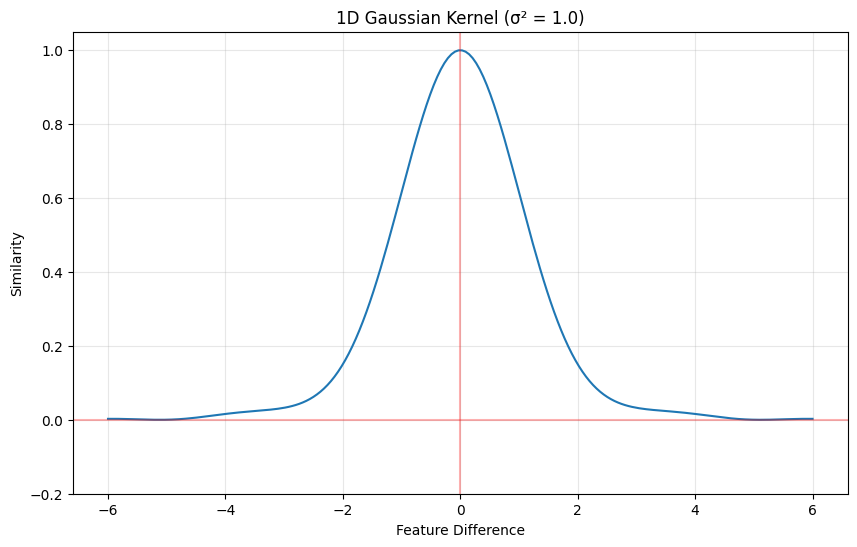

Experiment B: 2D Diagonal Gaussian


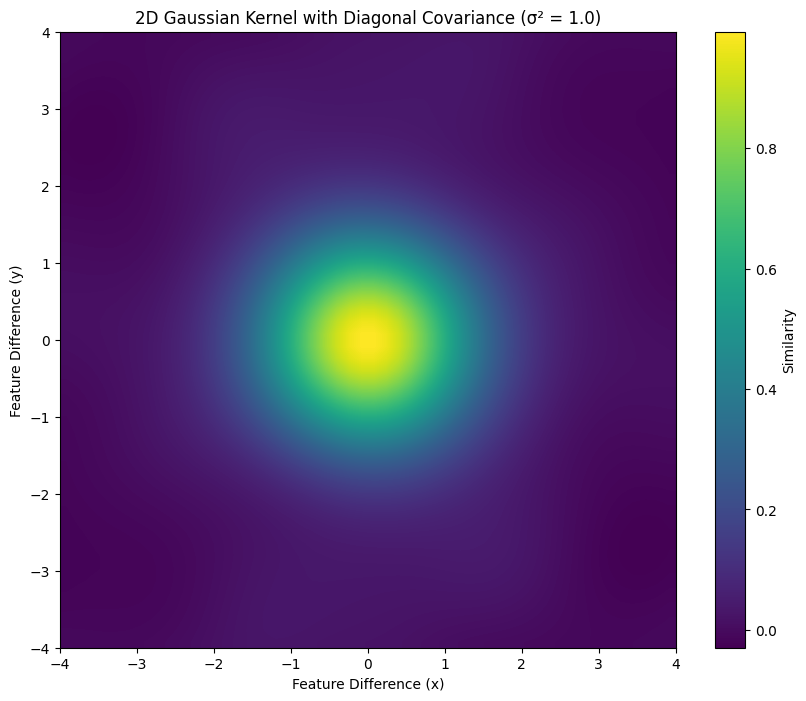

Experiment C: Bound 1D Gaussian


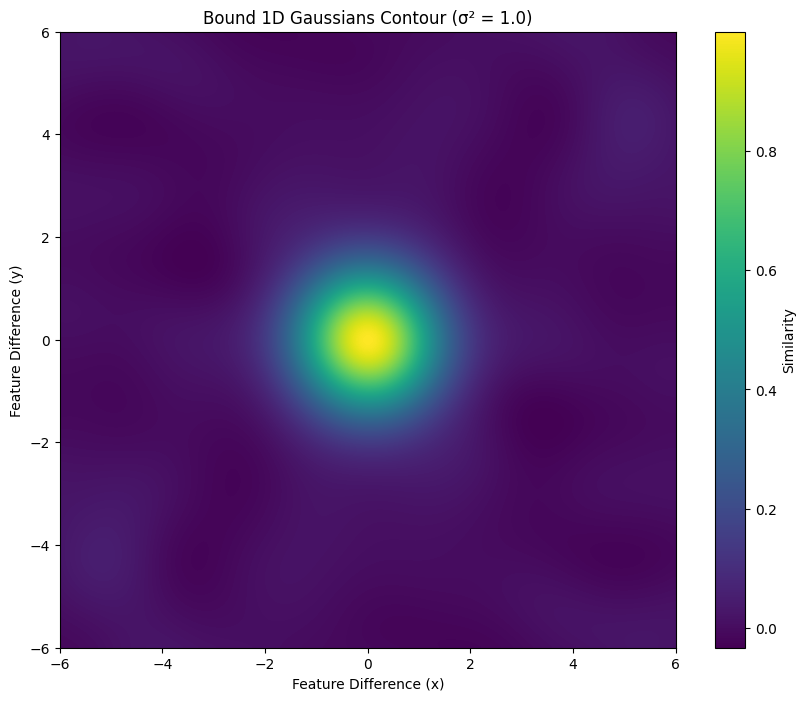

Experiment D: 2D Non-Diagonal Gaussian


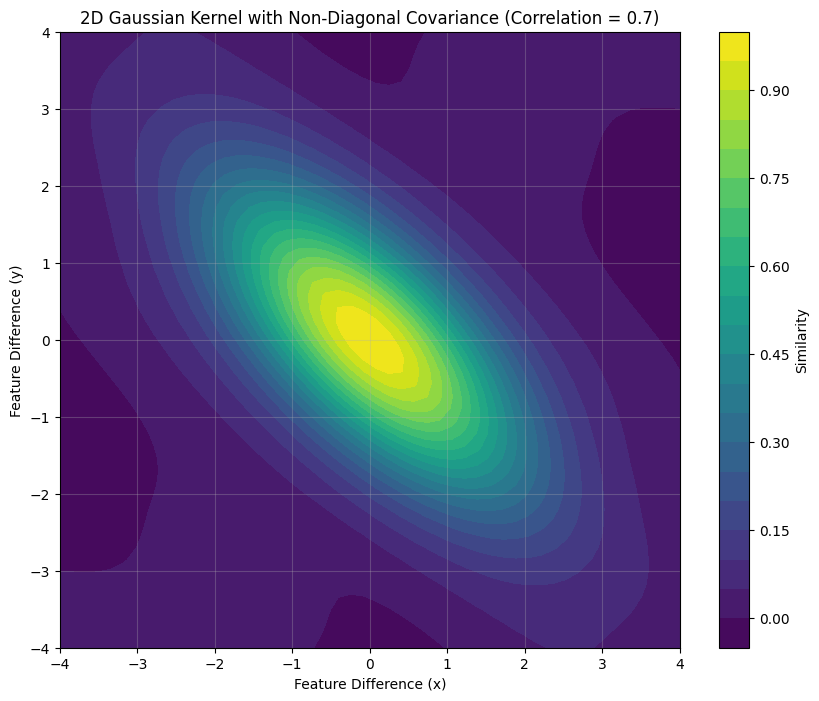

Experiment E: 1D Uniform


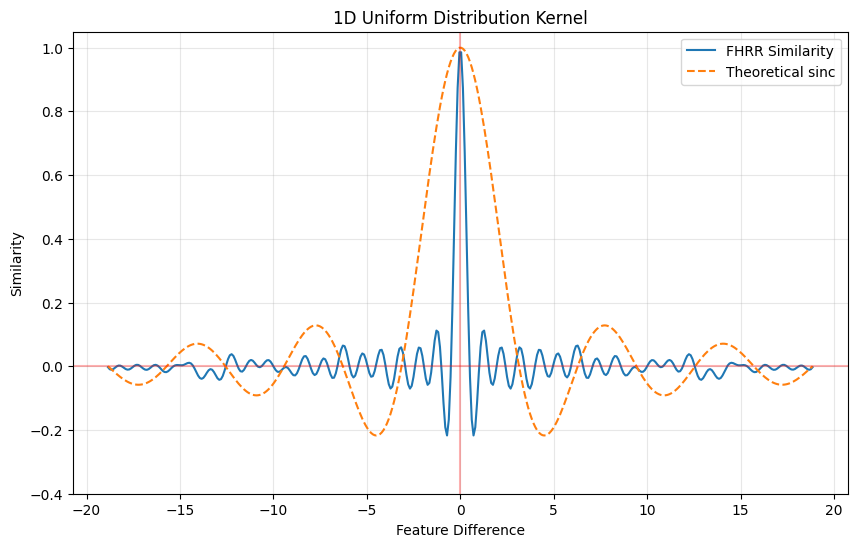

Experiment F: 2D Uniform


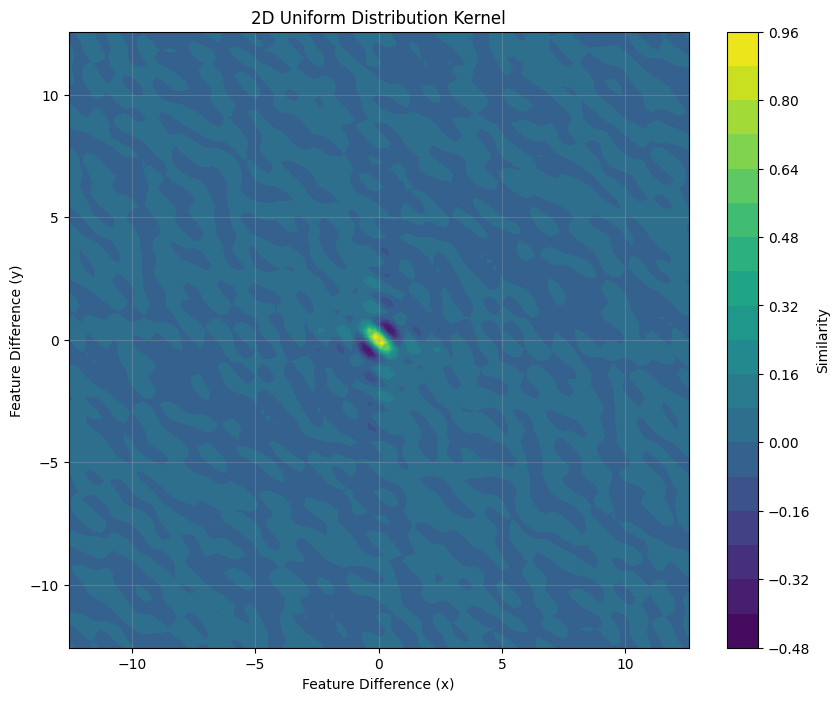

All experiments completed!


In [352]:
values = run_all_experiments()

## Classification of IRIS dataset

In [259]:
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score

In [ ]:
class RFFclassifier:
    def __init__(self, X_train, y_train, D=100):
        """
        Initializes the RFF classifier with the provided data and parameters.

        Args:
            X (np.ndarray) - feature matrix
            y (np.ndarray) - target labels
            D (int) - dimensionality of hyperdimensional representations
        """
        self.D = D
        self.y_train = y_train
        self.codebook = gen_basis(D, X_train.shape[1])
        self.encoded_train = encode_feature(self.codebook, X_train)
        self.num_classes = len(np.unique(self.y_train))
        self.class_hvs = np.zeros((self.num_classes, D), dtype=complex)

    def train(self, epochs=5, n_splits=5, iterate=False):
        """
        Train the model using k-fold cross-validation.

        Args:
            epochs (int) - Number of epochs to train.
            n_splits (int) - Number of splits for k-fold cross-validation.
            iterate (bool) - Whether to iteratively train in epochs.
        """
        # initialize class hypervectors
        for i in range(self.num_classes):
            class_hvs = np.zeros(self.D, dtype=complex)
            for hv in self.encoded_train[self.y_train == i]:
                class_hvs += (1 - fhrr_similarity(class_hvs, hv)) * hv
            self.class_hvs[i] = class_hvs

        train_accuracies = []
        val_accuracies = []

        if iterate:
            # KFold object for cross-validation
            kf = KFold(n_splits=n_splits, shuffle=True, random_state=37)

            for epoch in range(epochs):
                print(f"Epoch {epoch + 1}/{epochs}:")
                fold_train_accuracies = []
                fold_val_accuracies = []

                for fold, (train_idx, val_idx) in enumerate(kf.split(self.encoded_train)):
                    # split training/validation
                    X_train_fold = self.encoded_train[train_idx]
                    y_train_fold = self.y_train[train_idx]
                    X_val_fold = self.encoded_train[val_idx]
                    y_val_fold = self.y_train[val_idx]

                    # iterative training on train fold
                    for hv, label in zip(X_train_fold, y_train_fold):
                        similarities = [fhrr_similarity(hv, class_hv) for class_hv in self.class_hvs]
                        predicted = np.argmax(similarities)
                        if predicted != label:
                            self.class_hvs[label] += (1 - fhrr_similarity(self.class_hvs[label], hv)) * hv
                            self.class_hvs[predicted] -= hv

                    
                    train_predictions = self.predict(X_train_fold)
                    train_accuracy = accuracy_score(y_train_fold, train_predictions)
                    fold_train_accuracies.append(train_accuracy)

                    val_predictions = self.predict(X_val_fold)
                    val_accuracy = accuracy_score(y_val_fold, val_predictions)
                    fold_val_accuracies.append(val_accuracy)

                    print(f"  Fold {fold + 1}: Train Accuracy = {train_accuracy:.4f}, Validation Accuracy = {val_accuracy:.4f}")

                # avg accuracy across all folds
                train_epoch_accuracy = np.mean(fold_train_accuracies)
                val_epoch_accuracy = np.mean(fold_val_accuracies)
                train_accuracies.append(train_epoch_accuracy)
                val_accuracies.append(val_epoch_accuracy)

                print(f"Epoch {epoch + 1} Summary: Train Accuracy = {train_epoch_accuracy:.4f}, Validation Accuracy = {val_epoch_accuracy:.4f}")

        
        self.train_accuracies = train_accuracies
        self.val_accuracies = val_accuracies

    def predict(self, encoded_data):
        predictions = []
        for hv in encoded_data:
            similarities = [fhrr_similarity(hv, class_hv) for class_hv in self.class_hvs]
            predictions.append(np.argmax(similarities))
        return np.array(predictions)

    def score(self, test_features, test_labels):
        """
        Evaluates the model's performance on the test set and visualizes performance metrics.
        Args:
            test_features - the unencoded test features
            test_labels - true labels for test data
        Returns:
            float - test accuracy.
        """
        
        encoded_test = encode_feature(self.codebook, test_features)
        test_predictions = self.predict(encoded_test)
        test_accuracy = accuracy_score(test_labels, test_predictions)
        print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
        self.plot_metrics()
        return test_accuracy

    def plot_metrics(self):
        plt.figure(figsize=(8, 6))
        plt.plot(self.train_accuracies, label='Train Accuracy', marker='o')
        plt.plot(self.val_accuracies, label='Validation Accuracy', marker='o')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Training and Validation Accuracy per Epoch')
        plt.legend()
        plt.grid(True)
        plt.show()


In [325]:
iris = load_iris()
X, y = iris.data, iris.target
X = normalize(X, norm='l2')
X_train, X_test,y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=37)

Epoch 1/25:
  Fold 1: Train Accuracy = 0.6528, Validation Accuracy = 0.5556
  Fold 2: Train Accuracy = 0.6389, Validation Accuracy = 0.6111
  Fold 3: Train Accuracy = 0.6250, Validation Accuracy = 0.6667
  Fold 4: Train Accuracy = 0.6528, Validation Accuracy = 0.5556
  Fold 5: Train Accuracy = 0.5972, Validation Accuracy = 0.7778
Epoch 1 Summary: Train Accuracy = 0.6333, Validation Accuracy = 0.6333
Epoch 2/25:
  Fold 1: Train Accuracy = 0.6528, Validation Accuracy = 0.5556
  Fold 2: Train Accuracy = 0.6389, Validation Accuracy = 0.6111
  Fold 3: Train Accuracy = 0.6667, Validation Accuracy = 0.6667
  Fold 4: Train Accuracy = 0.6667, Validation Accuracy = 0.6111
  Fold 5: Train Accuracy = 0.7639, Validation Accuracy = 0.8333
Epoch 2 Summary: Train Accuracy = 0.6778, Validation Accuracy = 0.6556
Epoch 3/25:
  Fold 1: Train Accuracy = 0.8611, Validation Accuracy = 0.8889
  Fold 2: Train Accuracy = 0.7361, Validation Accuracy = 0.8333
  Fold 3: Train Accuracy = 0.8194, Validation Accuracy

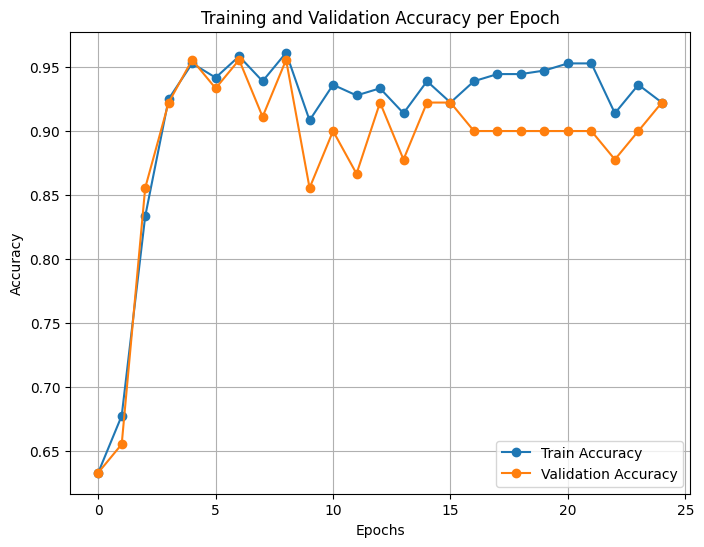

0.9666666666666667

In [294]:
model = RFFclassifier(X_train, y_train)
model.train(epochs=25, iterate=True)
model.score(X_test, y_test)